In [535]:
from PIL import Image
import cv2 
import numpy as np
import glob
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [ ]:
img_list = glob.glob("paris_train_original.nosync/*.JPG")

In [31]:
images = []
for i in img_list:
    pil_img = Image.open(i).convert('RGB')
    pil_img = np.array(pil_img)
    images.append(pil_img)
    
images = np.array(images)
images.shape

In [43]:
upper = [np.random.randint(0,537), np.random.randint(0,936)] 
lower = [np.random.randint(upper[0],537), np.random.randint(upper[1],936)] 



In [47]:
images[0][upper[0]:lower[0],upper[1]:lower[1]] = 255

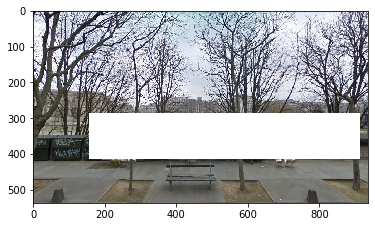

In [100]:
plt.imshow(images[0])

In [415]:
# TO FIX
# overlaps
# not exactly 25%
# Squares can differ in sizes 
def cover_percentage(img):
    img = img.copy()
    for i in range(8):
        img_perc_covered = img.flatten()
        img_perc_covered = np.count_nonzero( img_perc_covered == 255) / img_perc_covered.shape[0]
        if(img_perc_covered < 0.25):
            cover = [150,150]
            corner = [np.random.randint(0,537-cover[0]), np.random.randint(0,936-cover[1])] 
            img[corner[0]:cover[0]+corner[0],corner[1]:cover[1]+corner[1]] = 255
            
        else:
            img_perc_covered = img.flatten()
            #print((np.count_nonzero( img_perc_covered == 255) / img_perc_covered.shape[0])*100)
            break
    return img
            
            

# Data Formatting for pytorch + Train Test Split

In [520]:
class ToFillDataset_train(Dataset):
    def __init__(self, images, corrupted_images=None):
        self.images = images
        self.corrupted_images = corrupted_images
        
    def corrupt_image(self, img):
        img = img.copy()
        for i in range(8):
            img_perc_covered = img.flatten()
            img_perc_covered = np.count_nonzero( img_perc_covered == 255) / img_perc_covered.shape[0]
            if(img_perc_covered < 0.25):
                cover = [150,150]
                corner = [np.random.randint(0,537-cover[0]), np.random.randint(0,936-cover[1])] 
                img[corner[0]:cover[0]+corner[0],corner[1]:cover[1]+corner[1]] = 255
            else:
                img_perc_covered = img.flatten()
                break
        return img
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, item):
        image = self.images[item]
        
        if type(self.corrupted_images) == int :
            corrupt_images = self.corrupt_image(self.images[item])
        else:
            corrupt_images = self.corrupted_images[item]
            
        
        return {
          'image': image,
          'corrupt_image': corrupt_images ,
        }

In [521]:
def create_data_loader(images ,corrupt_images = 0 ):
    ds = ToFillDataset_train(images, corrupt_images)
    return DataLoader(ds, batch_size = 16) 

In [522]:
train = create_data_loader(images)

In [548]:
training_data_loaded = next(iter(train))

In [ ]:
for i in training_data_loaded:
    plt.imshow(i)

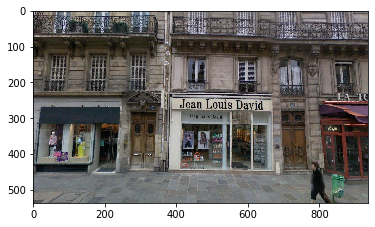

In [549]:
plt.imshow(training_data_loaded["image"][15])

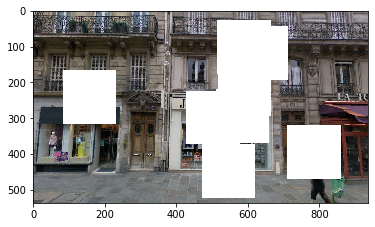

In [550]:
plt.imshow(training_data_loaded["corrupt_image"][15])

In [526]:
test_images_loc = glob.glob("paris_eval.nosync/paris_eval_gt/*.png")

In [527]:
test_images_corrupt_loc = glob.glob("paris_eval.nosync/paris_eval_corrupted/*.png")

In [528]:
test_images = []
for i in test_images_loc:
    pil_img = Image.open(i).convert('RGB')
    pil_img = np.array(pil_img)
    test_images.append(pil_img)
    
test_images = np.array(test_images)
test_images.shape

(100, 227, 227, 3)

In [529]:
test_images_corrupt = []
for i in test_images_corrupt_loc:
    pil_img = Image.open(i).convert('RGB')
    pil_img = np.array(pil_img)
    test_images_corrupt.append(pil_img)
    
test_images_corrupt = np.array(test_images_corrupt)
test_images_corrupt.shape

(100, 227, 227, 3)

In [530]:
test = create_data_loader(test_images,test_images_corrupt)

In [531]:
testing_data_loaded = next(iter(test))

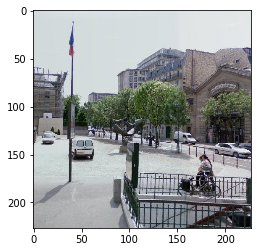

In [533]:
plt.imshow(testing_data_loaded["image"][10])

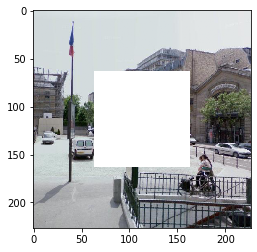

In [536]:
plt.imshow(testing_data_loaded["corrupt_image"][10])

In [557]:
img_list[:9]

['paris_train_original.nosync/48.857282_2.338481_90_-004.JPG',
 'paris_train_original.nosync/48.863699_2.366359_270_-004.JPG',
 'paris_train_original.nosync/48.845369_2.358046_90_-004.JPG',
 'paris_train_original.nosync/48.860149_2.356713_270_-004.JPG',
 'paris_train_original.nosync/48.843288_2.341758_90_-004.JPG',
 'paris_train_original.nosync/48.854727_2.350595_90_-004.JPG',
 'paris_train_original.nosync/48.863540_2.346353_270_-004.JPG',
 'paris_train_original.nosync/48.844949_2.349006_90_-004.JPG',
 'paris_train_original.nosync/48.849107_2.362840_270_-004.JPG']

In [552]:
i = img_list[9]

In [556]:
i[25:]

'nc/48.851623_2.347760_270_-004.JPG'

In [573]:
glob.glob("paris*/*/")

['paris_eval.nosync/paris_eval_corrupted/', 'paris_eval.nosync/paris_eval_gt/']

In [577]:
from torch import nn


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16 
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 128 x 128
            nn.Tanh()
            
        )
    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16 
            nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size. 1
        )
    def forward(self, input):
        return self.main(input)

In [578]:
    # Number of channels in the training images. For color images this is 3
    nc = 3
    # Size of z latent vector (i.e. size of generator input)
    nz = 100
    # Size of feature maps in generator
    ngf = 227
    # Size of feature maps in discriminator
    ndf = 227
Generator(0)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 3632, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(3632, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(3632, 1816, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1816, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1816, 908, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(908, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(908, 454, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(454, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(454, 227, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Ba